In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Load datasets
products_df = pd.read_csv('Products.csv')
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset for inspection
display(products_df.head(30), customers_df.head(), transactions_df.head())


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31
5,P006,ActiveWear Rug,Home Decor,121.32
6,P007,SoundWave Cookbook,Books,420.15
7,P008,BookWorld Bluetooth Speaker,Electronics,146.85
8,P009,BookWorld Wall Art,Home Decor,325.01
9,P010,ComfortLiving Smartwatch,Electronics,350.13


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [20]:
# Merge datasets
merged_data = transactions_df.merge(customers_df, on="CustomerID", how="left")
merged_data = merged_data.merge(products_df, on="ProductID", how="left")

# Display the structure of the merged data
print(merged_data.info())
display(merged_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price_x          1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
 10  ProductName      1000 non-null   object 
 11  Category         1000 non-null   object 
 12  Price_y          1000 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB
None


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [4]:
# Aggregate data at the customer level
customer_features = merged_data.groupby("CustomerID").agg(
    total_purchase_value=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    num_unique_categories=("Category", "nunique"),
    total_quantity=("Quantity", "sum"),
    region=("Region", "first"),
).reset_index()

# One-hot encode the 'region' column
customer_features = pd.get_dummies(customer_features, columns=["region"], prefix="region")

# Display the aggregated data
print(customer_features.info())
display(customer_features.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             199 non-null    object 
 1   total_purchase_value   199 non-null    float64
 2   num_transactions       199 non-null    int64  
 3   num_unique_categories  199 non-null    int64  
 4   total_quantity         199 non-null    int64  
 5   region_Asia            199 non-null    bool   
 6   region_Europe          199 non-null    bool   
 7   region_North America   199 non-null    bool   
 8   region_South America   199 non-null    bool   
dtypes: bool(4), float64(1), int64(3), object(1)
memory usage: 8.7+ KB
None


,CustomerID,total_purchase_value,num_transactions,num_unique_categories,total_quantity,region_Asia,region_Europe,region_North America,region_South America
0,C0001,3354.52,5,3,12,False,False,False,True
1,C0002,1862.74,4,2,10,True,False,False,False
2,C0003,2725.38,4,3,14,False,False,False,True
3,C0004,5354.88,8,3,23,False,False,False,True
4,C0005,2034.24,3,2,7,True,False,False,False


In [5]:
# Normalize numerical features
numerical_features = ["total_purchase_value", "num_transactions", "num_unique_categories", "total_quantity"]
scaler = StandardScaler()
customer_features_scaled = customer_features.copy()
customer_features_scaled[numerical_features] = scaler.fit_transform(customer_features[numerical_features])

# Prepare data for clustering (exclude CustomerID)
clustering_data = customer_features_scaled.drop(columns=["CustomerID"])


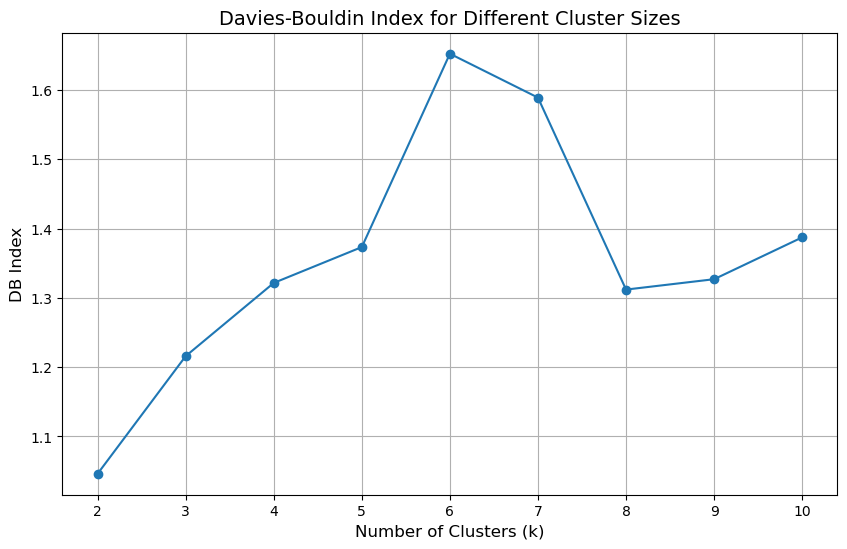

Optimal number of clusters: 2
Minimum DB Index: 1.0462558697180544


In [6]:
# Apply KMeans clustering with varying cluster sizes (2 to 10)
db_indices = []
models = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(clustering_data)
    db_index = davies_bouldin_score(clustering_data, clusters)
    db_indices.append(db_index)
    models.append((k, kmeans, clusters))

# Plot DB Index values for different cluster sizes
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_indices, marker='o')
plt.title("Davies-Bouldin Index for Different Cluster Sizes", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("DB Index", fontsize=12)
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Identify the optimal number of clusters
optimal_k = range(2, 11)[db_indices.index(min(db_indices))]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Minimum DB Index: {min(db_indices)}")


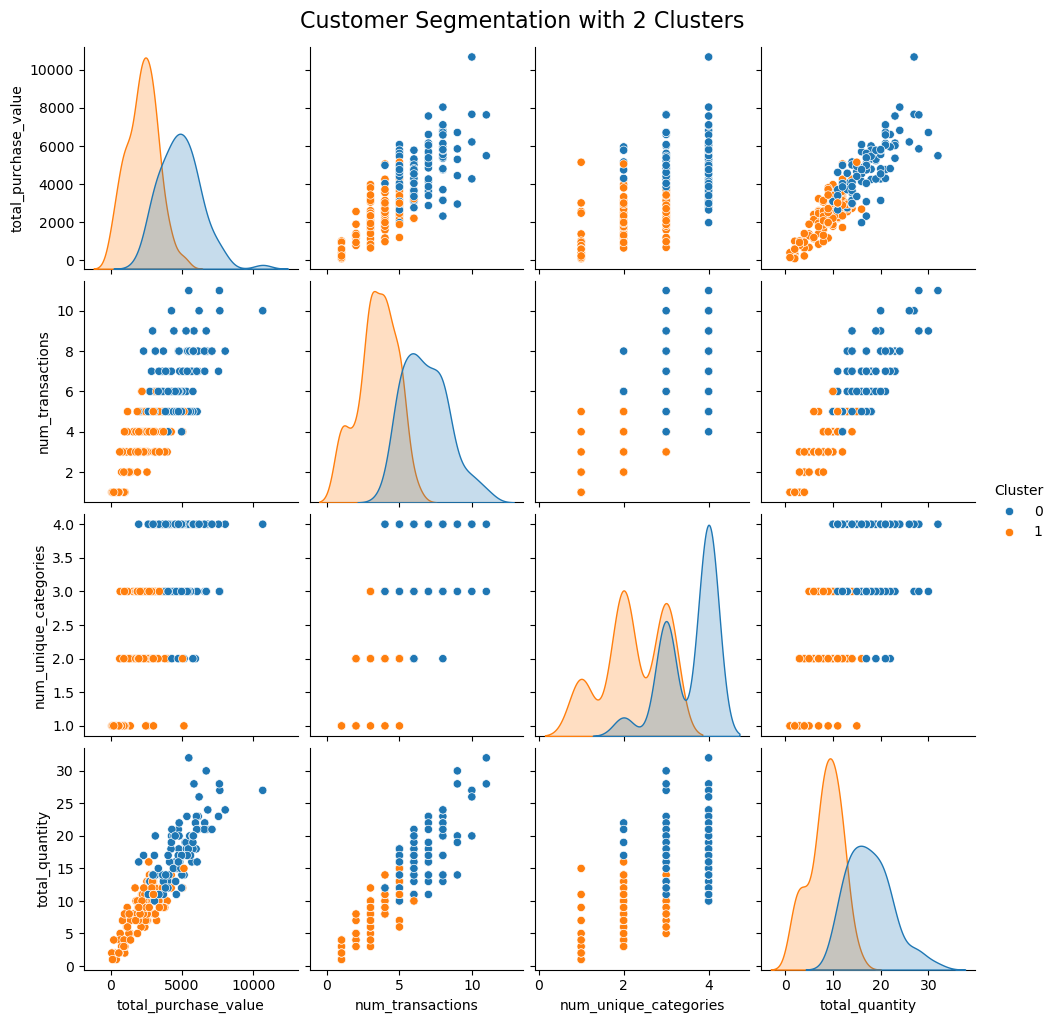

In [7]:
# Get the optimal clustering results
optimal_model = models[optimal_k - 2]  # Corresponds to (k, model, clusters)
optimal_kmeans = optimal_model[1]
optimal_clusters = optimal_model[2]

# Add cluster labels to the original customer data
customer_features['Cluster'] = optimal_clusters

# Visualize the clusters using a pairplot
sns.pairplot(customer_features, vars=numerical_features, hue='Cluster', palette='tab10', diag_kind='kde')
plt.suptitle(f"Customer Segmentation with {optimal_k} Clusters", y=1.02, fontsize=16)
plt.show()


In [25]:
from nbconvert import HTMLExporter
from weasyprint import HTML

def save_notebook_as_pdf_without_latex(notebook_name: str, output_pdf_name: str):
    # Load the notebook
    with open(notebook_name, 'r', encoding='utf-8') as nb_file:
        nb_content = nb_file.read()
    
    # Convert the notebook to HTML
    html_exporter = HTMLExporter()
    html_data, _ = html_exporter.from_notebook_node(nbformat.reads(nb_content, as_version=4))
    
    # Convert the HTML to PDF using WeasyPrint
    HTML(string=html_data).write_pdf(output_pdf_name)

# Example usage
save_notebook_as_pdf_without_latex("User_Segmentation.ipynb", "Himanshu_Jha_Clustering.pdf")


ModuleNotFoundError: No module named 'weasyprint'